In [1]:
from nilearn import plotting

/home/pbellec/env/cneuromod_embeddings/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


# Parameters

In [2]:
import os
from cneuromod_embeddings.dypac_utils import get_root_data

subject = "sub-01"
state = 256

# Set up file names... where to find the data.
path_data = get_root_data('models')
bg_img = os.path.join(path_data, f"{subject}_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz")
parcels = os.path.join(path_data, f"{subject}_space-MNI152NLin2009cAsym_desc-dypac{state}_components.nii.gz")
mask = os.path.join(path_data, f"{subject}_space-MNI152NLin2009cAsym_label-GM_mask.nii.gz")

# Grey matter mask

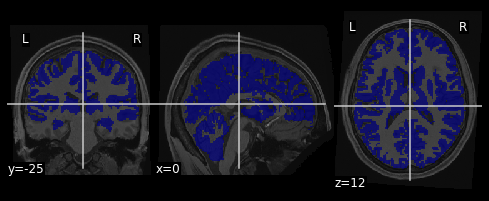

In [3]:
from nilearn.image import index_img
plotting.plot_roi(mask, bg_img=bg_img, resampling_interpolation='nearest')

# Loading parcels

In [4]:
from nilearn.image import load_img
from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_img=mask, detrend=False, smoothing_fwhm=0)
components = masker.fit_transform(parcels)
components.shape

/home/pbellec/env/cneuromod_embeddings/lib/python3.8/site-packages/nilearn/image/image.py:214: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


(255, 121576)

In [34]:
mask_v = masker.fit_transform(mask)

/home/pbellec/env/cneuromod_embeddings/lib/python3.8/site-packages/nilearn/image/image.py:214: UserWarning: The parameter 'fwhm' for smoothing is specified as 0. Setting it to None (no smoothing will be performed)
  warnings.warn("The parameter 'fwhm' for smoothing is specified "


In [35]:
mask_v.shape

(1, 121576)

# Inter-parcel similarity and clustering

Number of clusters found 30


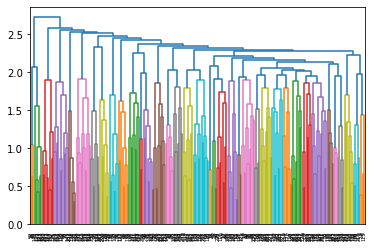

In [5]:
import numpy as np
from nilearn.connectome import ConnectivityMeasure
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree

conn = np.squeeze(ConnectivityMeasure(kind='correlation').fit_transform([components.transpose()]))

# That's the hierarchical clustering step
hier = linkage(conn, method='average', metric='euclidean') # scipy's hierarchical clustering
# HAC proceeds by iteratively merging brain regions, which can be visualized with a tree
res = dendrogram(hier, get_leaves=True) # Generate a dendrogram from the hierarchy

# the order of merging above give us a good order to visualize the matrix
order = res.get('leaves') # Extract the order on parcels from the dendrogram

# We can cut the tree at whatever distance we choose
part = np.squeeze(cut_tree(hier, n_clusters=30)) # Cut the hierarchy
print(f"Number of clusters found {np.max(part) + 1}")

# Group parcels into clusters

(<AxesSubplot:title={'center':'inter-parcel similarity'}>,
 Text(0.5, 1.0, 'inter-parcel similarity'))

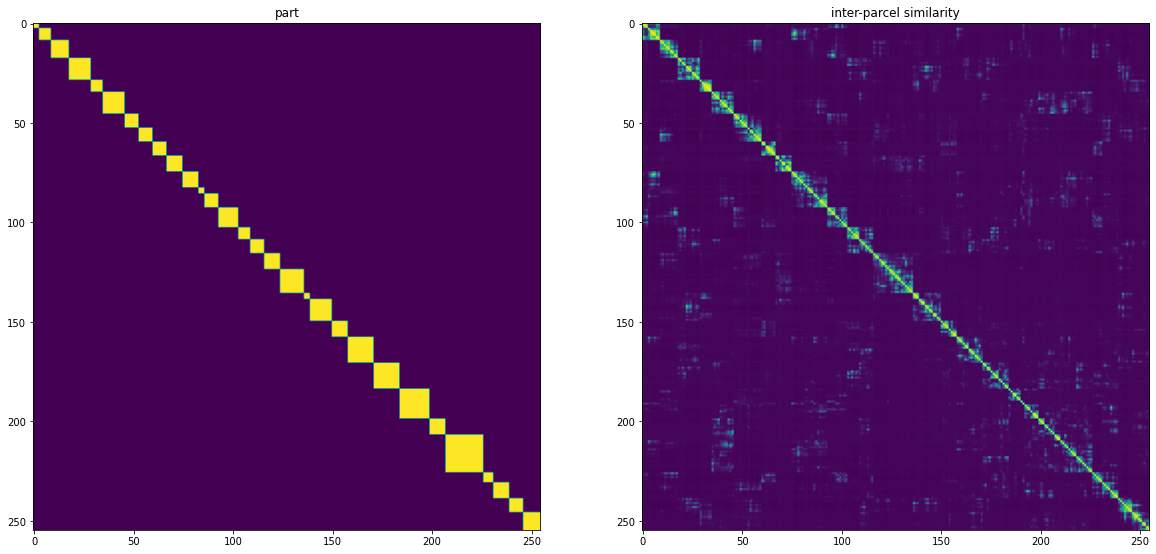

In [6]:
# Generate correlation matrix between parcels
from nilearn.connectome import ConnectivityMeasure
conn = np.squeeze(ConnectivityMeasure(kind='correlation').fit_transform([components.transpose()]))

# Another way to represent the clusters is an adjacency matrix A
# A(i,j) = 1 if i and j are in the same cluster, and 0 otherwise
def part2adj(part):
    part = np.reshape(part, [part.shape[0], 1])
    adj = np.repeat(part, part.shape[0], 1) == np.repeat(part.transpose(), part.shape[0], 0)
    return adj.astype(int)

import matplotlib.pyplot as plt
width_fig = 20
fig = plt.figure(figsize=(width_fig, width_fig * 0.5))
# Let's look at the adjacency matrix
# alongside the connectivity matrix, after reordering
plt.subplot(1,2,1), plt.imshow(part2adj(part[order])), plt.title('part')
plt.subplot(1,2,2), plt.imshow(conn[order, :][:, order]), plt.title('inter-parcel similarity')

# Cluster table

In [7]:
import pandas as pd
n_cluster = np.max(part) + 1
table = pd.DataFrame(columns=['parcel', 'size', 'homogeneity', 'label'])
for num_c in range(n_cluster):
    hom = np.mean(conn[part==num_c, :][:, part==num_c])
    siz = np.sum(part==num_c)
    table.loc[num_c] = [num_c, siz, hom, '']
pd.set_option("display.max_rows", None)
table

,parcel,size,homogeneity,label
0,0,9,0.368571,
1,1,15,0.150632,
2,2,11,0.281706,
3,3,13,0.248360,
4,4,8,0.337069,
5,5,19,0.150090,
6,6,8,0.440109,
7,7,3,0.878084,
8,8,3,0.870701,
9,9,6,0.693446,


# Labels
subject='sub-03', state=256, n_clusters=30

In [8]:
table['label'].loc[0]  = ['']
table['label'].loc[1]  = ['']
table['label'].loc[2]  = ['']
table['label'].loc[3]  = ['']
table['label'].loc[4]  = ['']
table['label'].loc[5]  = ['']
table['label'].loc[6]  = ['']
table['label'].loc[7]  = ['']
table['label'].loc[8]  = ['']
table['label'].loc[9]  = ['']
table['label'].loc[10] = ['']
table['label'].loc[11] = ['']
table['label'].loc[12] = ['']
table['label'].loc[13] = ['']
table['label'].loc[14] = ['']
table['label'].loc[15] = ['']
table['label'].loc[16] = ['']
table['label'].loc[17] = ['']
table['label'].loc[18] = ['']
table['label'].loc[19] = ['']
table['label'].loc[20] = ['']
table['label'].loc[21] = ['']
table['label'].loc[22] = ['']
table['label'].loc[23] = ['']
table['label'].loc[24] = ['']
table['label'].loc[25] = ['']
table['label'].loc[26] = ['']
table['label'].loc[27] = ['']
table['label'].loc[28] = ['']
table['label'].loc[29] = ['']

/home/pbellec/env/cneuromod_embeddings/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


# Visualize clusters

/home/pbellec/env/cneuromod_embeddings/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:341: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


Text(0.5, 0.98, "['']")

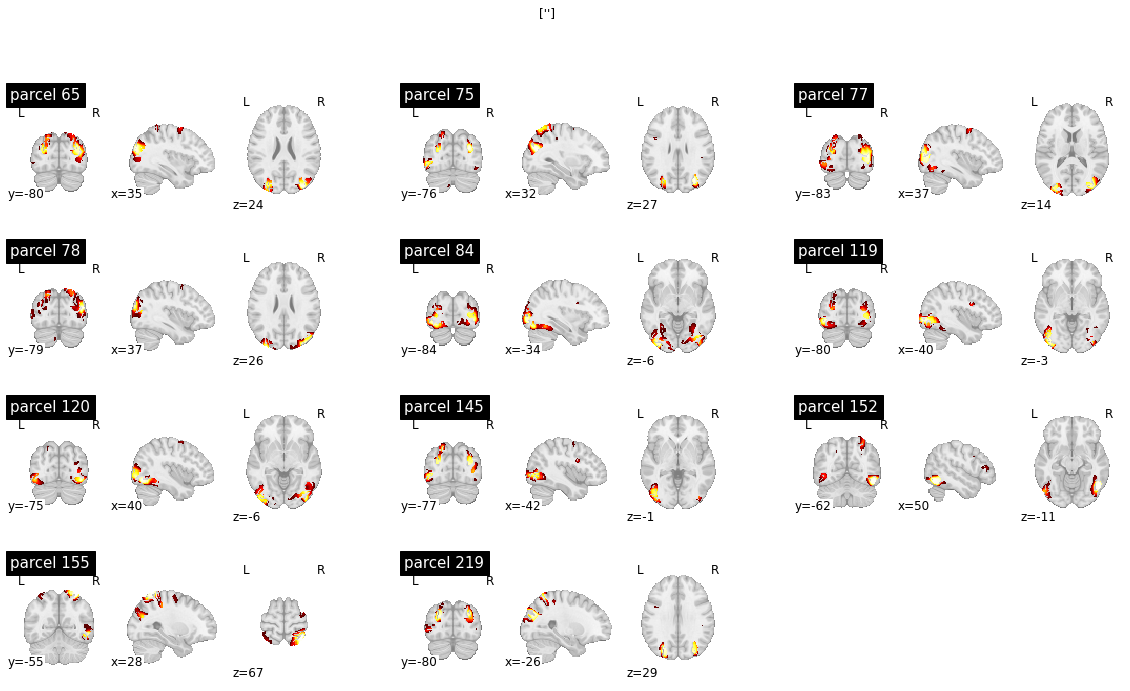

In [9]:
num_p = 23
width_fig = 20
list_parcel = np.nonzero(part == num_p)[0]
n_comp = len(list_parcel)
n_rows = int(np.ceil(n_comp / 3))
fig = plt.figure(figsize=(width_fig, n_comp))

for num, parcel in enumerate(list_parcel):
    ax_plot = plt.subplot(n_rows, 3, num + 1)
    plotting.plot_stat_map(
        masker.inverse_transform(components[parcel, :]), 
        display_mode="ortho",
        axes=ax_plot,
        threshold=0.1,
        vmax=1,
        colorbar=False,
        draw_cross=False,
        title=f"parcel {parcel}"
    )
fig.suptitle(table['label'].loc[num_p])

# Check number of states

(array([ 1089.,  4711., 11144., 25448., 31257., 26654., 14435.,  4586.,
         1460.,   792.]),
 array([0.        , 0.63122211, 1.26244423, 1.89366634, 2.52488846,
        3.15611057, 3.78733269, 4.4185548 , 5.04977692, 5.68099903,
        6.31222115]),
 <BarContainer object of 10 artists>)

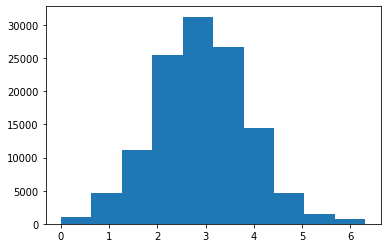

In [10]:
import matplotlib.pyplot as plt
components_clean = components
mask_part = [part[num] in [] for num in range(components.shape[0])]
components_clean[mask_part, :] = 0 # remove cardiac components
components_clean[components < 0.1] = 0
plt.hist(np.sum(components_clean, axis=0))


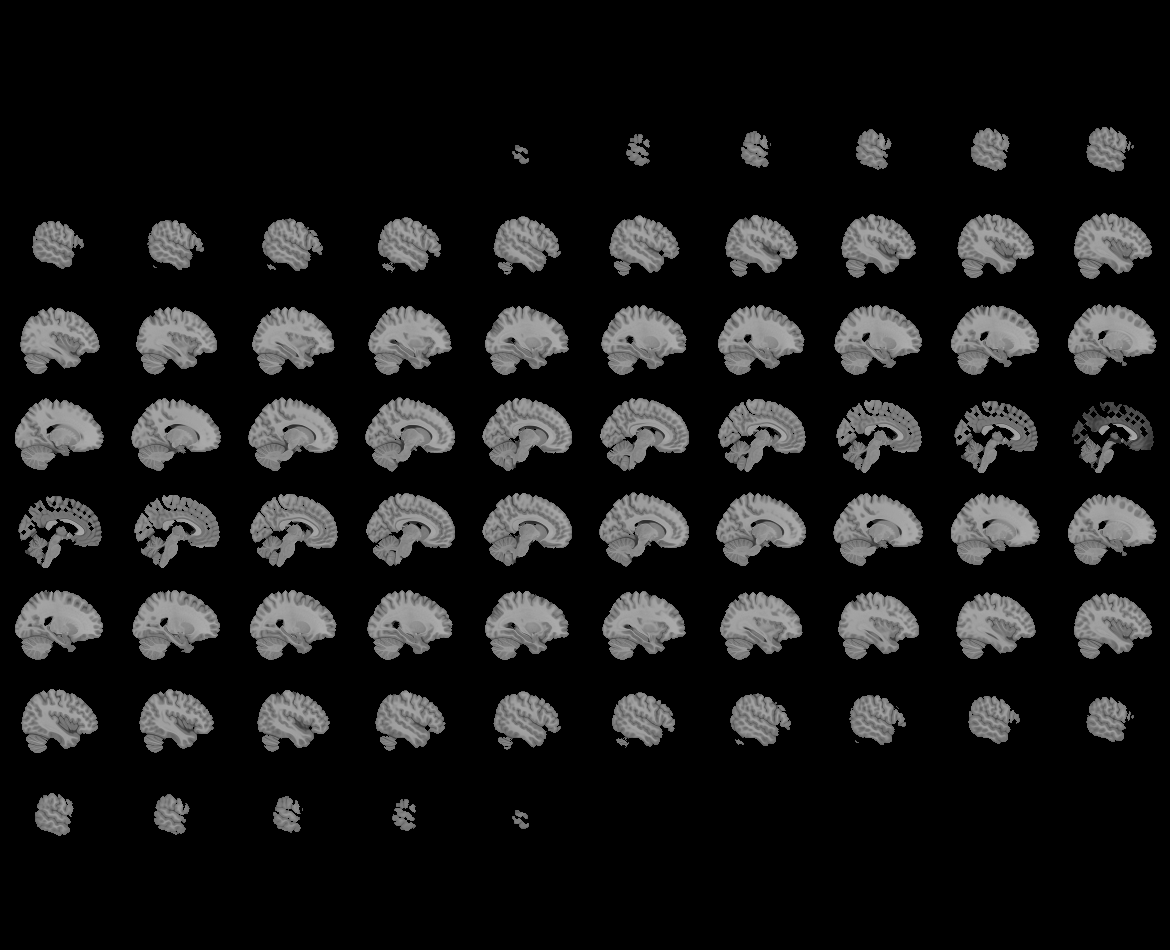
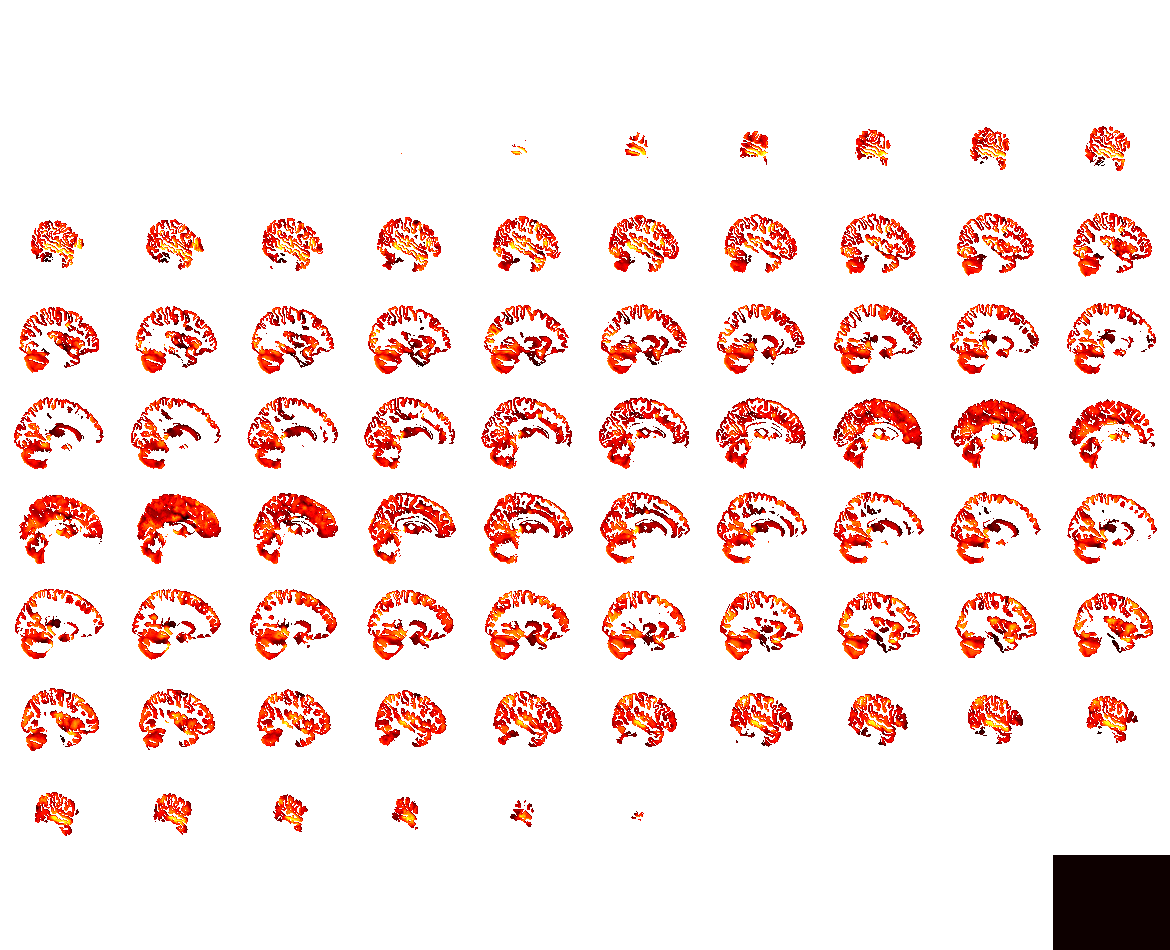

In [11]:
import numpy as np
plotting.view_img(
        masker.inverse_transform(np.sum(components_clean, axis=0)), 
        display_mode="ortho",
        threshold=0.1,
        vmax=8,
        colorbar=True,
        draw_cross=False,
        title=f"parcel {parcel}"
    )

/tmp/ipykernel_41030/2139036215.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


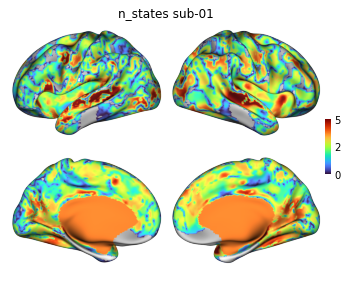

In [33]:
from neuromaps.datasets import fetch_fslr
from surfplot.datasets import load_example_data

surfaces = fetch_fslr()
lh, rh = surfaces['inflated']
sulc_lh, sulc_rh = surfaces['sulc']

from neuromaps.transforms import mni152_to_fslr
gii_lh, gii_rh = mni152_to_fslr(masker.inverse_transform(np.sum(components_clean, axis=0)))

from nilearn.plotting.cm import _cmap_d as nilearn_cmaps
from surfplot import Plot
# cold_hot is a common diverging colormap for neuroimaging
p = Plot(lh, rh)
p.add_layer({'left': sulc_lh, 'right': sulc_rh}, cmap='binary_r', cbar=False)
cmap = nilearn_cmaps['cold_hot']
p.add_layer({'left': gii_lh, 'right': gii_rh}, cmap='turbo',
            color_range=(0, 5))

# make a nice vertical colorbar on the right side of the figure
kws = dict(location='right', draw_border=False, aspect=10, shrink=.2,
           decimals=0, pad=0)
fig = p.build(cbar_kws=kws)
fig.axes[0].set_title(f'n_states {subject}', pad=-3)
fig.show()